# Scoring & Analyzing Knowledge

For the first six knowledge-based questions, responses are recorded as checkboxes, allowing multiple selections per question. To calculate a knowledge score, each question is scored out of 1 point. When a question has multiple correct answers, the 1 point is evenly divided among them. For example, if a question has three correct options, each correct selection contributes approximately 0.333 points to the total score.

### List of Correct Answers for Knowledge Assessment Questions


#### 1. Causes of dental caries

b. Frequent ingestion of sugar

c. Dynamics of oral micro-flora

d. Inadequate tooth brushing

#### 2. Causes of bleeding during tooth brushing

b. Periodontal disease

c. Brushing too hard

d. Systemic disease
  

#### 3. Influence of dental plaque

a. Affecting appearance

b. Inducing dental caries

c. Including periodontal diseases

#### 4. Measures that prevent oral diseases

a. Application of fluoride

b. Pit & fissure sealing

c. Tooth scaling

#### 5. Systemic diseases related to oral diseases

a. Heart diseases

b. Diabetes mellitus

c. Hypertension

f. Other diseases (if justified in open field, optional)

#### 6. Which is more important for oral health?

a. Self-administration of oral hygiene

In [238]:
%pip install matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [239]:
df = pd.read_csv("../data/processed/oral-health-uofg-cleaned.csv")

In [240]:
academic_level_mapping = {
    "First year": "1st Year",
    "Second year": "2nd Year",
    "Third year": "3rd Year",
    "Fourth year": "4th Year",
    "Fifth year": "5th Year",
}
df["Academic level"] = df["Academic level"].map(academic_level_mapping)
df

,RecordID,Timestamp,Are you a student at University of Gezira?,Age,Gender,Faculty,Academic level,Causes of dental caries,Causes of bleeding during tooth brushing:,Influence of dental plaque:,Measures that prevent oral diseases:,Systemic diseases that may be related to oral diseases:,Which is more important for oral health: self-administration or dentist?:,Frequency of daily tooth brushing.,Duration of tooth brushing.,Frequency of replacing tooth brush.,Frequency of visiting dentist.,Method of tooth brushing:,Oral hygiene methods besides tooth brushing:,What oral health problem(s) do you have (you can choose more than one):
0,0,9/24/2023 22:01:24,Yes,23.0,Male,Medicine,4th Year,"Toothpaste without fluoride, Frequent ingestio...",Brushing too hard,Affecting appearance,Application of fluoride,Heart diseases,Self-administration of oral hygiene,1,2 to 3 minutes,Every three months,When I have a dental problem/oral disease,Irregular,Mouthwash,Abnormal growth of last molar in the left side...
1,1,9/24/2023 22:04:16,Yes,25.0,Male,Medicine,5th Year,Dynamic of oral micro-flora,Periodontal disease,Affecting appearance,Application of fluoride,Heart diseases,Self-administration of oral hygiene,2,More than 3 minutes,Every three months,Twice a year,Horizontal scrub,Mouthwash,Dental caries
2,2,9/24/2023 22:05:24,Yes,24.0,Male,Dentistry,4th Year,"Frequent ingestion of sugar, Dynamic of oral m...","Natural physiological phenomenon, Brushing too...",Don't know,"Application of fluoride, Pit & fissure sealing","None of the above, Other diseases",Regular visit to dentist,2,2 to 3 minutes,Every three months,Twice a year,Modified pass technique,Toothpick,No problem
3,3,9/24/2023 22:09:19,Yes,25.0,Male,Medicine,5th Year,"Frequent ingestion of sugar, Inadequate tooth ...","Periodontal disease, Brushing too hard, System...","Affecting appearance, Inducing dental caries, ...","Application of fluoride, Tooth scaling","Heart diseases, Diabetes mellitus, Hypertension",Self-administration of oral hygiene,1,More than 3 minutes,Every three months,Once a year,Vertical scrub,Mouthwash,Toothache
4,4,9/24/2023 22:09:26,Yes,20.0,Male,Medicine,3rd Year,"Frequent ingestion of sugar, Dynamic of oral m...","Brushing too hard, Systemic disease","Affecting appearance, Inducing dental caries",Application of fluoride,None of the above,Regular visit to dentist,1,2 to 3 minutes,Until it can't be used,When I have a dental problem/oral disease,Horizontal scrub,Sugar-free chewing gum,Toothache
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,403,9/27/2024 8:18:21,Yes,24.0,Male,Medicine,4th Year,"Dynamic of oral micro-flora, Inadequate tooth ...","Brushing too hard, Systemic disease","Affecting appearance, Inducing dental caries, ...",Application of fluoride,"Diabetes mellitus, Other diseases",Self-administration of oral hygiene,2,More than 3 minutes,Every two months,Once a year,Modified pass technique,Mouthwash,Tooth hypersensitivity
397,404,9/27/2024 8:22:00,Yes,24.0,Male,Medicine,4th Year,"Frequent ingestion of sugar, Dynamic of oral m...","Periodontal disease, Brushing too hard",Affecting appearance,"Application of fluoride, Tooth scaling","Heart diseases, Diabetes mellitus","Self-administration of oral hygiene, Regular v...",2,2 to 3 minutes,Every three months,When I have a dental problem/oral disease,Modified pass technique,Mouthwash,Oral ulcers
398,405,9/27/2024 13:57:21,Yes,25.0,Female,Medicine,5th Year,"Toothpaste without fluoride, Frequent ingestio...","Natural physiological phenomenon, Periodontal ...","Inducing dental caries, Including periodontal ...",Tooth scaling,Diabetes mellitus,Self-administration of oral hygiene,More than 2,2 to 3 minutes,Every month,More than 2 times a year,Modified pass technique,"Dental floss, Mouthwash, Sugar-free chewing gum","Dental caries, Gingival bleeding, Oral ulcers,..."
399,406,9/27/2024 19:07:55,Yes,25.0,Male,Medicine,4th Year,"Toothpaste without fluoride, Frequent ingestio...","Brushing too h

In [241]:
df_knowledge = df[
    [
        "RecordID",
        "Faculty",
        "Academic level",
        "Causes of dental caries",
        "Causes of bleeding during tooth brushing:",
        "Influence of dental plaque:",
        "Measures that prevent oral diseases:",
        "Systemic diseases that may be related to oral diseases:",
        "Which is more important for oral health: self-administration or dentist?:",
    ]
].copy()
df_knowledge.rename(
    columns={
        "Causes of dental caries": "Q1",
        "Causes of bleeding during tooth brushing:": "Q2",
        "Influence of dental plaque:": "Q3",
        "Measures that prevent oral diseases:": "Q4",
        "Systemic diseases that may be related to oral diseases:": "Q5",
        "Which is more important for oral health: self-administration or dentist?:": "Q6",
    },
    inplace=True,
)

In [242]:
questions = {
    "Q1": "causes_of_dental_caries",
    "Q2": "causes_of_bleeding_during_tooth_brushing",
    "Q3": "influence_of_dental_plaque",
    "Q4": "measures_that_prevent_oral_diseases",
    "Q5": "systemic_diseases_related_to_oral_diseases",
    "Q6": "importance_of_self_administration_vs_dentist",
}

In [243]:
%pip install scipy

from scipy.stats import chi2_contingency


def compute_pvalues_chi(df_long, group_col, value_col, question_col):
    """_summary_
    aa
        Args:
            df_long (_type_): a wide format DataFrame with columns for group, value, and question
            group_col (_type_): a list of columns that are used to group the data.
            value_col (_type_): The value column that contains the numerical data to be analyzed.
            question_col (_type_): The column that contains the question options.
    """
    pvals = {}
    if isinstance(group_col, str):
        group_col = [group_col]

    for question_option in df_long[question_col].unique():
        data = df_long[df_long[question_col] == question_option]
        # I have to introduce the loop here to groupby academic level and later by faculty
        # group by the first grouping column (e.g., academic_level)
        if len(group_col) != 2:
            contingency_table = pd.crosstab(data[group_col[0]], data[value_col])
            if contingency_table.shape[1] < 2:
                pvals[question_option] = float("nan")
                continue
            # run chi-square test of independence
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            pvals[question_option] = p
        else:
            for first_group_val, subgroup in data.groupby(group_col[0]):
                # create contingency table with rows = second grouping column (e.g., faculty)
                # columns = value_col (0/1)
                contingency_table = pd.crosstab(
                    subgroup[group_col[1]], subgroup[value_col]
                )

                # If the table is degenerate (e.g., no variation), skip or assign p=nan
                if contingency_table.shape[1] < 2:
                    pvals[(question_option, first_group_val)] = float("nan")
                    continue

                # run chi-square test of independence
                chi2, p, dof, expected = chi2_contingency(contingency_table)
                pvals[(question_option, first_group_val)] = p

    return pvals


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [244]:
def final_table(table_academic_level, pvals):
    # Assuming table_academic_level is your pivot table with MultiIndex columns
    # And pvals is your dictionary: keys=(question, academic_level), values=p-value

    # Step 1: Create empty DataFrame for p-values
    pval_df = pd.DataFrame(index=table_academic_level.index)

    # Get all unique academic levels in the order they appear in the columns
    academic_levels = table_academic_level.columns.get_level_values(0).unique()

    for level in academic_levels:
        # Build a Series of p-values for all questions for this academic level
        pvals_for_level = {
            question: pvals.get((question, level), np.nan)
            for question in table_academic_level.index
        }
        pval_series = pd.Series(pvals_for_level, index=table_academic_level.index)

        # Add to pval_df with MultiIndex column
        pval_df[(level, "p-value")] = pval_series

    # Concatenate pval_df to original pivot table
    combined = pd.concat([table_academic_level, pval_df], axis=1)

    # Reorder columns to put 'p-value' after each academic level's faculties
    new_cols = []

    for level in academic_levels:
        # Get all columns for this level excluding p-value
        level_faculties = [
            col for col in table_academic_level.columns if col[0] == level
        ]
        new_cols.extend(level_faculties)
        # Append the p-value column for this level
        new_cols.append((level, "p-value"))

    # Select columns in new order
    final_table = combined[new_cols]
    return final_table

In [245]:
def print_tables(df, one_hot, question_col):
    df_join = df.join(one_hot)
    df_long = df_join.melt(
        id_vars=["Faculty", "Academic level"],  # keep these columns as they are
        value_vars=[col for col in one_hot.columns],  # question columns
        var_name=question_col,
        value_name="Selected",
    )
    table_faculty = df_long.pivot_table(
        values="Selected", index=question_col, columns=["Faculty"], aggfunc=np.mean
    ).round(2)
    table_faculty.columns.name = None

    # Compute p-values for the faculty table
    pvals = compute_pvalues_chi(
        df_long, group_col=["Faculty"], value_col="Selected", question_col=question_col
    )
    pval_series = pd.Series(pvals, index=table_faculty.index)
    table_with_p_faculty = pd.concat(
        [table_faculty, pval_series.rename("p-value")], axis=1
    )
    table_with_p_faculty.columns.name = None

    # Now create the table for academic level and faculty
    table_academic_level = df_long.pivot_table(
        values="Selected",
        index=question_col,
        columns=["Academic level", "Faculty"],
        aggfunc=np.mean,
    ).round(2)
    table_academic_level.columns.name = None
    pvals = compute_pvalues_chi(
        df_long,
        group_col=["Academic level", "Faculty"],
        value_col="Selected",
        question_col=question_col,
    )
    table_with_p_academic = final_table(table_academic_level, pvals)

    return table_with_p_academic, table_with_p_faculty

In [246]:
%pip install dataframe_image

import dataframe_image as dfi


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [247]:
%pip install scikit-learn

from sklearn.preprocessing import MultiLabelBinarizer


def score_checkbox_question(df, question_col, correct_answers):
    df["Q_split"] = df[question_col].str.split(", ")

    mlb = MultiLabelBinarizer()
    one_hot = pd.DataFrame(
        mlb.fit_transform(df["Q_split"]), columns=mlb.classes_, index=df.index
    )
    correct_mask = one_hot[correct_answers]
    df[f"{question_col}_score"] = correct_mask.sum(axis=1) / len(correct_answers)
    df.drop(columns=["Q_split"], inplace=True)

    table1, table2 = print_tables(df.copy(), one_hot, question_col)

    # Export the tables as images
    if question_col in questions:
        dfi.export(
            table1,
            f"../results/tables/{questions[question_col]}_level_faculty.png",
            table_conversion="chrome",
        )
        dfi.export(
            table2,
            f"../results/tables/{questions[question_col]}_faculty.png",
            table_conversion="chrome",
        )

    return table1, table2


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [248]:
table1, table2 = score_checkbox_question(
    df_knowledge,
    "Q1",
    [
        "Frequent ingestion of sugar",
        "Dynamic of oral micro-flora",
        "Inadequate tooth brushing",
    ],
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:9: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:25: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


1st Year                     2nd Year           \
                            Dentistry Medicine   p-value Dentistry Medicine   
Q1                                                                            
Don't know                       0.00     0.28  0.201385      0.13     0.09   
Dynamic of oral micro-flora      0.12     0.13  1.000000      0.33     0.43   
Frequent ingestion of sugar      0.75     0.54  0.482087      0.73     0.70   
Inadequate tooth brushing        0.62     0.52  0.875644      0.73     0.85   
Toothpaste without fluoride      0.50     0.20  0.158435      0.33     0.52   

                                       3rd Year                     4th Year  \
                              p-value Dentistry Medicine   p-value Dentistry   
Q1                                                                             
Don't know                   0.980413      0.14     0.07  1.000000      0.00   
Dynamic of oral micro-flora  0.695438      0.14     0.46  0.222843      0.57   
Frequent ingestion of sugar  1.000000      0.86     0.65  0.489616      1.00   
Inadequate tooth brushing    0.538624      0.43     0.73  0.197760      0.76   
Toothpaste without fluoride  0.331470      0.14     0.28  0.737783      0.52   

                                                5th Year                     
                            Medicine   p-value Dentistry Medicine   p-value  
Q1                                                                           
Don't know                      0.03  1.000000      0.00     0.04  1.000000  
Dynamic of oral micro-flora     0.52  0.892939      0.44     0.51  1.000000  
Frequent ingestion of sugar     0.69  0.009199      0.78     0.60  0.504227  
Inadequate tooth brushing       0.71  0.840138      0.56     0.81  0.189106  
Toothpaste without fluoride     0.32  0.163065      0.33     0.33  1.000000

In [249]:
table2

,Dentistry,Medicine,p-value
Q1,,,
Don't know,0.05,0.09,0.505776
Dynamic of oral micro-flora,0.38,0.43,0.554852
Frequent ingestion of sugar,0.85,0.64,0.002259
Inadequate tooth brushing,0.67,0.73,0.365597
Toothpaste without fluoride,0.40,0.32,0.284443


In [250]:
table1, table2 = score_checkbox_question(
    df_knowledge, "Q2", ["Periodontal disease", "Brushing too hard", "Systemic disease"]
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:9: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:25: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


1st Year                     2nd Year  \
                                 Dentistry Medicine   p-value Dentistry   
Q2                                                                        
Brushing too hard                     0.75     0.72  1.000000      0.87   
Don't know                            0.12     0.13  1.000000      0.00   
Natural physiological phenomenon      0.00     0.15  0.540238      0.07   
Periodontal disease                   0.62     0.35  0.275115      1.00   
Systemic disease                      0.25     0.24  1.000000      0.20   

                                                     3rd Year           \
                                 Medicine   p-value Dentistry Medicine   
Q2                                                                       
Brushing too hard                    0.85  1.000000      0.57     0.79   
Don't know                           0.11  0.429109      0.14     0.05   
Natural physiological phenomenon     0.11  1.000000      0.00     0.14   
Periodontal disease                  0.48  0.001010      0.86     0.50   
Systemic disease                     0.48  0.109458      0.29     0.44   

                                            4th Year                     \
                                   p-value Dentistry Medicine   p-value   
Q2                                                                        
Brushing too hard                 0.374602      0.71     0.92  0.034446   
Don't know                        0.849633      0.00     0.05  0.750382   
Natural physiological phenomenon  0.635462      0.10     0.17  0.636511   
Periodontal disease               0.143455      0.95     0.43  0.000084   
Systemic disease                  0.703525      0.38     0.63  0.078967   

                                  5th Year                     
                                 Dentistry Medicine   p-value  
Q2                                                             
Brushing too hard                     0.67     0.83  0.449182  
Don't know                            0.00     0.01  1.000000  
Natural physiological phenomenon      0.00     0.08  0.806780  
Periodontal disease                   1.00     0.55  0.025568  
Systemic disease                      0.56     0.72  0.508104

In [251]:
table2

,Dentistry,Medicine,p-value
Q2,,,
Brushing too hard,0.73,0.82,1.402965e-01
Don't know,0.03,0.06,6.264147e-01
Natural physiological phenomenon,0.05,0.13,1.241967e-01
Periodontal disease,0.92,0.48,6.031716e-10
Systemic disease,0.33,0.52,1.060629e-02


In [252]:
table1, table2 = score_checkbox_question(
    df_knowledge,
    "Q3",
    [
        "Affecting appearance",
        "Inducing dental caries",
        "Including periodontal diseases",
    ],
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:9: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:25: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


1st Year                     2nd Year  \
                               Dentistry Medicine   p-value Dentistry   
Q3                                                                      
Affecting appearance                0.25     0.35  0.892269      0.53   
Don't know                          0.12     0.48  0.139507      0.27   
Including periodontal diseases      0.38     0.20  0.505756      0.40   
Inducing dental caries              0.75     0.24  0.013929      0.40   
Not a big deal                      0.00     0.09  0.892269      0.00   

                                                   3rd Year           \
                               Medicine   p-value Dentistry Medicine   
Q3                                                                     
Affecting appearance               0.33  0.257864      0.43     0.46   
Don't know                         0.52  0.154677      0.14     0.41   
Including periodontal diseases     0.15  0.094457      0.71     0.30   
Inducing dental caries             0.28  0.595049      0.57     0.40   
Not a big deal                     0.11  0.429109      0.00     0.07   

                                          4th Year                     \
                                 p-value Dentistry Medicine   p-value   
Q3                                                                      
Affecting appearance            1.000000      0.52     0.60  0.718181   
Don't know                      0.327138      0.05     0.26  0.074026   
Including periodontal diseases  0.062395      0.71     0.26  0.000517   
Inducing dental caries          0.606158      0.81     0.46  0.011318   
Not a big deal                  1.000000      0.05     0.02  0.984550   

                                5th Year                     
                               Dentistry Medicine   p-value  
Q3                                                           
Affecting appearance                0.22     0.59  0.078835  
Don't know                          0.22     0.22  1.000000  
Including periodontal diseases      0.56     0.29  0.209047  
Inducing dental caries              0.56     0.52  1.000000  
Not a big deal                      0.00     0.10  0.724851

In [253]:
table2

,Dentistry,Medicine,p-value
Q3,,,
Affecting appearance,0.43,0.48,0.560137
Don't know,0.15,0.36,0.002568
Including periodontal diseases,0.57,0.26,0.000003
Inducing dental caries,0.63,0.40,0.001402
Not a big deal,0.02,0.07,0.174157


In [254]:
table1, table2 = score_checkbox_question(
    df_knowledge,
    "Q4",
    ["Application of fluoride", "Pit & fissure sealing", "Tooth scaling"],
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:9: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:25: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


1st Year                     2nd Year           \
                        Dentistry Medicine   p-value Dentistry Medicine   
Q4                                                                        
Application of fluoride      0.62     0.61  1.000000      0.73     0.61   
Don't know                   0.50     0.33  0.582579      0.07     0.26   
Pit & fissure sealing        0.12     0.13  1.000000      0.13     0.33   
Tooth scaling                0.12     0.28  0.615800      0.47     0.41   

                                   3rd Year                     4th Year  \
                          p-value Dentistry Medicine   p-value Dentistry   
Q4                                                                         
Application of fluoride  0.573186      0.71     0.58  0.779571      1.00   
Don't know               0.217973      0.00     0.22  0.368893      0.00   
Pit & fissure sealing    0.265138      0.57     0.24  0.132847      0.86   
Tooth scaling            0.948917      0.43     0.41  1.000000      0.71   

                                            5th Year                     
                        Medicine   p-value Dentistry Medicine   p-value  
Q4                                                                       
Application of fluoride     0.62  0.001948      0.78     0.65  0.692516  
Don't know                  0.22  0.047213      0.00     0.19  0.324004  
Pit & fissure sealing       0.28  0.000009      0.89     0.29  0.001283  
Tooth scaling               0.55  0.295734      0.56     0.46  0.836458

In [255]:
table2

,Dentistry,Medicine,p-value
Q4,,,
Application of fluoride,0.82,0.61,0.003822
Don't know,0.08,0.23,0.015024
Pit & fissure sealing,0.55,0.26,0.000009
Tooth scaling,0.52,0.43,0.275932


In [256]:
table1, table2 = score_checkbox_question(
    df_knowledge,
    "Q5",
    ["Heart diseases", "Diabetes mellitus", "Hypertension", "Other diseases"],
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:9: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:25: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


1st Year                     2nd Year                     \
                  Dentistry Medicine   p-value Dentistry Medicine   p-value   
Q5                                                                            
Cancer                 0.50     0.22  0.212605      0.60     0.33  0.113769   
Diabetes mellitus      0.25     0.30  1.000000      0.47     0.41  0.948917   
Don't know             0.25     0.37  0.800632      0.27     0.39  0.573186   
Heart diseases         0.25     0.15  0.863978      0.27     0.13  0.403130   
Hypertension           0.12     0.15  1.000000      0.07     0.09  1.000000   
None of the above      0.00     0.11  0.750370      0.00     0.07  0.743790   
Other diseases         0.12     0.17  1.000000      0.27     0.33  0.912000   

                   3rd Year                     4th Year                     \
                  Dentistry Medicine   p-value Dentistry Medicine   p-value   
Q5                                                                            
Cancer                 0.29     0.37  0.981967      0.52     0.37  0.318232   
Diabetes mellitus      0.86     0.51  0.172423      0.81     0.60  0.136722   
Don't know             0.00     0.13  0.680706      0.00     0.08  0.439346   
Heart diseases         0.43     0.47  1.000000      0.38     0.60  0.133390   
Hypertension           0.00     0.20  0.423012      0.38     0.14  0.034798   
None of the above      0.14     0.03  0.618323      0.05     0.03  1.000000   
Other diseases         0.43     0.32  0.846719      0.48     0.40  0.718181   

                   5th Year                     
                  Dentistry Medicine   p-value  
Q5                                              
Cancer                 0.44     0.35  0.842393  
Diabetes mellitus      1.00     0.55  0.025568  
Don't know             0.00     0.10  0.724851  
Heart diseases         0.44     0.54  0.836458  
Hypertension           0.56     0.18  0.030460  
None of the above      0.00     0.01  1.000000  
Other diseases         0.33     0.40  0.987528

In [257]:
table2

,Dentistry,Medicine,p-value
Q5,,,
Cancer,0.50,0.34,0.022966
Diabetes mellitus,0.68,0.50,0.012298
Don't know,0.10,0.18,0.185891
Heart diseases,0.35,0.42,0.364390
Hypertension,0.25,0.16,0.137573
None of the above,0.03,0.04,1.000000
Other diseases,0.35,0.33,0.929064


In [258]:
table1, table2 = score_checkbox_question(
    df_knowledge, "Q6", ["Self-administration of oral hygiene"]
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:9: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/458505097.py:25: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


1st Year                     2nd Year  \
                                    Dentistry Medicine   p-value Dentistry   
Q6                                                                           
Regular visit to dentist                 0.88     0.63  0.343110      0.87   
Self-administration of oral hygiene      0.50     0.67  0.582579      0.40   

                                                        3rd Year           \
                                    Medicine   p-value Dentistry Medicine   
Q6                                                                          
Regular visit to dentist                0.52  0.038416      0.57     0.52   
Self-administration of oral hygiene     0.83  0.004175      0.71     0.78   

                                             4th Year                     \
                                    p-value Dentistry Medicine   p-value   
Q6                                                                         
Regular visit to dentist                1.0      0.67     0.55  0.511371   
Self-administration of oral hygiene     1.0      0.67     0.77  0.516427   

                                     5th Year                     
                                    Dentistry Medicine   p-value  
Q6                                                                
Regular visit to dentist                 0.89     0.52  0.076256  
Self-administration of oral hygiene      0.44     0.80  0.053404

In [259]:
table2

,Dentistry,Medicine,p-value
Q6,,,
Regular visit to dentist,0.77,0.54,0.001947
Self-administration of oral hygiene,0.55,0.77,0.000476


<aside>
📌

When comparing faculties across different academic levels, the p-values I observed show considerable variation. Some questions yield very high p-values, while others produce quite low ones. This variability is likely due to the small sample sizes within each faculty-level subgroup, which reduces the statistical power and makes it harder to detect consistent significant differences.

On the other hand, when comparing faculties without stratifying by academic level, the p-values tend to be more stable. Although some p-values remain high, suggesting no significant difference, others indicate meaningful distinctions between faculties. This broader comparison benefits from larger group sizes, improving the reliability of the results.

Moving forward, I will be calculating the significance of differences using student scores derived from correct responses per question. Since these scores are continuous measures at the individual level, I will employ t-tests to assess differences between faculties and academic levels more robustly. The goal is to see if the differences might appear better if more balanced comparisons within faculties or academic levels are used.

</aside>

In [260]:
df["knowledge_score"] = (
    df_knowledge[
        ["Q1_score", "Q2_score", "Q3_score", "Q4_score", "Q5_score", "Q6_score"]
    ].sum(axis=1)
    / 6
)
group_faculty = df.groupby("Faculty")["knowledge_score"].mean()

<Axes: xlabel='Faculty'>

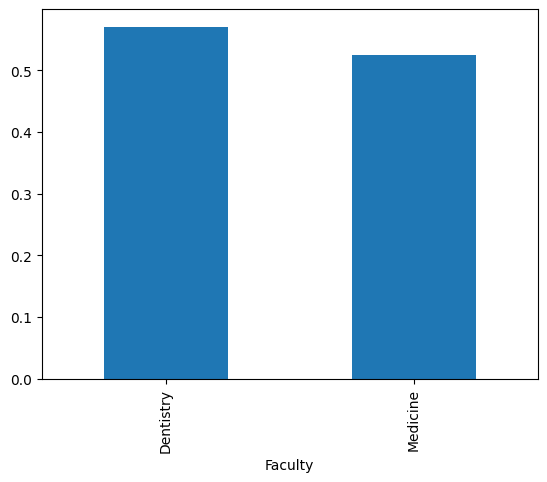

In [261]:
group_faculty.plot(kind="bar")

In [262]:
grouped = df.groupby(["Faculty", "Academic level"])["knowledge_score"].mean()
grouped

Faculty    Academic level
Dentistry  1st Year          0.413194
           2nd Year          0.474074
           3rd Year          0.555556
           4th Year          0.696429
           5th Year          0.591049
Medicine   1st Year          0.384058
           2nd Year          0.504831
           3rd Year          0.522690
           4th Year          0.571581
           5th Year          0.581158
Name: knowledge_score, dtype: float64


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


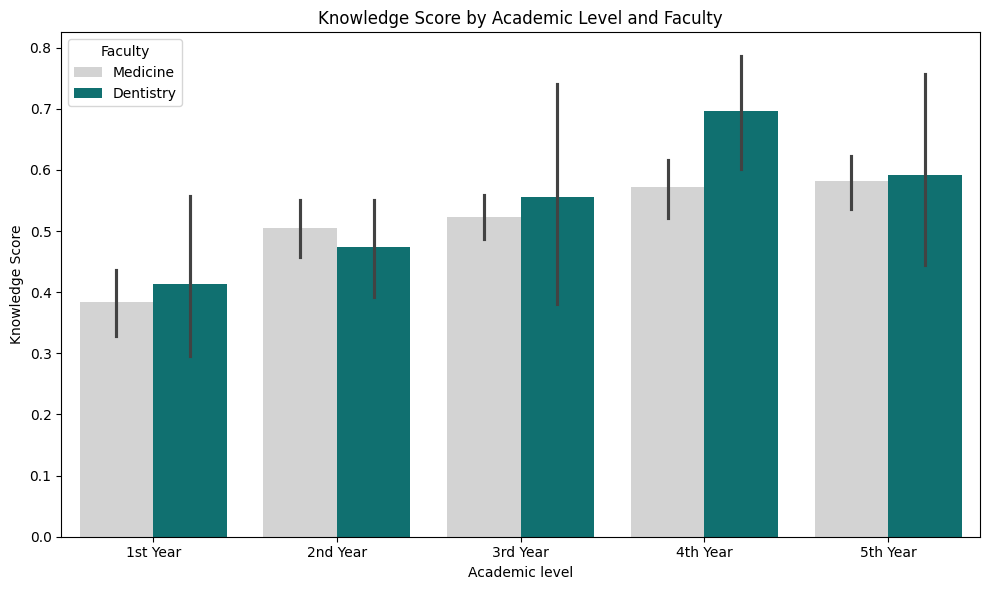

In [289]:
%pip install seaborn

import seaborn as sns

# Assign colors
palette = {"Dentistry": "teal", "Medicine": "lightgray"}
order = ["1st Year", "2nd Year", "3rd Year", "4th Year", "5th Year"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="Academic level",
    y="knowledge_score",
    hue="Faculty",
    order=order,
    palette=palette,
)

plt.title("Knowledge Score by Academic Level and Faculty")
plt.ylabel("Knowledge Score")
plt.tight_layout()
plt.show()

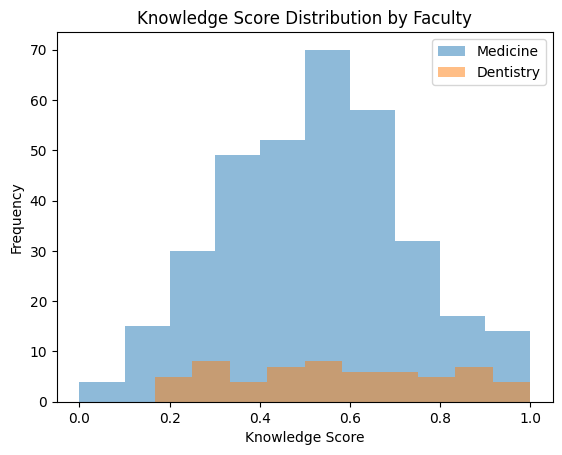

In [264]:
faculties = df["Faculty"].unique()

for faculty in faculties:
    subset = df[df["Faculty"] == faculty]
    plt.hist(subset["knowledge_score"], bins=10, alpha=0.5, label=faculty)

plt.legend()
plt.xlabel("Knowledge Score")
plt.ylabel("Frequency")
plt.title("Knowledge Score Distribution by Faculty")
plt.show()

Although the sample size of Dentistry students is relatively small, they still demonstrate higher levels of knowledge compared to Medical students. However, the observed difference in knowledge between the two groups is considered minimal.

The progression of improved knowledge while advancing through the academic levels is also evident although minimal.

In [265]:
df.describe()

,RecordID,Age,knowledge_score
count,401.000000,401.000000,401.000000
mean,204.256858,22.124688,0.531969
std,117.644428,2.453449,0.209500
min,0.000000,18.000000,0.000000
25%,103.000000,20.000000,0.375000
50%,205.000000,22.000000,0.541667
75%,305.000000,24.000000,0.666667
max,407.000000,35.000000,1.000000


In [266]:
np.median(df["knowledge_score"])

0.5416666666666666

In [267]:
np.var(df["knowledge_score"], ddof=1)

0.043890089109787256

## Descriptive Analytics for Score of Knowledge of Healthcare students
mean = 0.53

mode = 0.54

median = 0.54

std = 0.20

variance = 0.043 -> fairly clustered

{'whiskers': [<matplotlib.lines.Line2D at 0x16c9f2cb0>,
 'caps': [<matplotlib.lines.Line2D at 0x16c9f3190>,
 'boxes': [<matplotlib.lines.Line2D at 0x16c9f29b0>],
 'medians': [<matplotlib.lines.Line2D at 0x16c9f3790>],
 'fliers': [<matplotlib.lines.Line2D at 0x16c9f3a90>],
 'means': []}

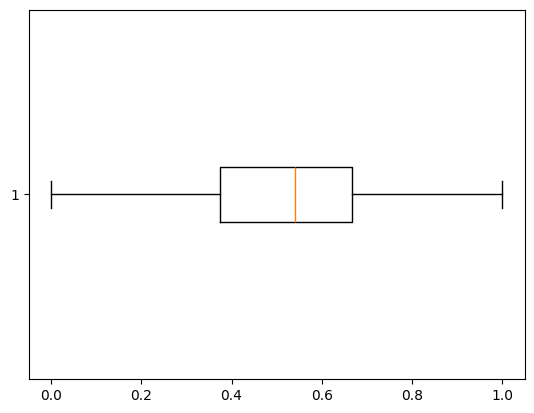

In [268]:
plt.boxplot(df["knowledge_score"], vert=False)

Let's calculate if there's any outliers

In [269]:
Q1 = df["knowledge_score"].quantile(0.25)
Q3 = df["knowledge_score"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[
    (df["knowledge_score"] < lower_bound) | (df["knowledge_score"] > upper_bound)
]
outliers  # No outliers found!

,RecordID,Timestamp,Are you a student at University of Gezira?,Age,Gender,Faculty,Academic level,Causes of dental caries,Causes of bleeding during tooth brushing:,Influence of dental plaque:,...,Systemic diseases that may be related to oral diseases:,Which is more important for oral health: self-administration or dentist?:,Frequency of daily tooth brushing.,Duration of tooth brushing.,Frequency of replacing tooth brush.,Frequency of visiting dentist.,Method of tooth brushing:,Oral hygiene methods besides tooth brushing:,What oral health problem(s) do you have (you can choose more than one):,knowledge_score


In [270]:
df_knowledge.head()

,RecordID,Faculty,Academic level,Q1,Q2,Q3,Q4,Q5,Q6,Q1_score,Q2_score,Q3_score,Q4_score,Q5_score,Q6_score
0,0,Medicine,4th Year,"Toothpaste without fluoride, Frequent ingestio...",Brushing too hard,Affecting appearance,Application of fluoride,Heart diseases,Self-administration of oral hygiene,1.000000,0.333333,0.333333,0.333333,0.25,1.0
1,1,Medicine,5th Year,Dynamic of oral micro-flora,Periodontal disease,Affecting appearance,Application of fluoride,Heart diseases,Self-administration of oral hygiene,0.333333,0.333333,0.333333,0.333333,0.25,1.0
2,2,Dentistry,4th Year,"Frequent ingestion of sugar, Dynamic of oral m...","Natural physiological phenomenon, Brushing too...",Don't know,"Application of fluoride, Pit & fissure sealing","None of the above, Other diseases",Regular visit to dentist,1.000000,0.333333,0.000000,0.666667,0.25,0.0
3,3,Medicine,5th Year,"Frequent ingestion of sugar, Inadequate tooth ...","Periodontal disease, Brushing too hard, System...","Affecting appearance, Inducing dental caries, ...","Application of fluoride, Tooth scaling","Heart diseases, Diabetes mellitus, Hypertension",Self-administration of oral hygiene,0.666667,1.000000,1.000000,0.666667,0.75,1.0
4,4,Medicine,3rd Year,"Frequent ingestion of sugar, Dynamic of oral m...","Brushing too hard, Systemic disease","Affecting appearance, Inducing dental caries",Application of fluoride,None of the above,Regular visit to dentist,1.000000,0.666667,0.666667,0.333333,0.00,0.0


In [271]:
df_knowledge_scores = df_knowledge[
    [
        "Faculty",
        "Academic level",
        "Q1_score",
        "Q2_score",
        "Q3_score",
        "Q4_score",
        "Q5_score",
        "Q6_score",
    ]
].copy()

In [272]:
import scipy.stats as stats


def compute_pvalues_ttest(df_long, group_col, value_col, question_col):
    pvals = {}
    for question_option in df_long[question_col].unique():
        data = df_long[df_long[question_col] == question_option]
        if isinstance(group_col, str):
            groups = [
                group[value_col].values for name, group in data.groupby(group_col)
            ]

            if len(groups) == 2:
                stat, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
            else:
                stat, p = stats.f_oneway(*groups)

            pvals[question_option] = p

        else:
            for first_group_val, subgroup in data.groupby(group_col[0]):
                # Create two groups based on the second grouping column
                groups = [
                    group[value_col].values
                    for name, group in subgroup.groupby(group_col[1])
                ]
                if len(groups) == 2:
                    stat, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
                else:
                    stat, p = stats.f_oneway(*groups)

                pvals[(question_option, first_group_val)] = p

    return pvals

In [273]:
df_long = df_knowledge_scores.melt(
    id_vars=["Faculty", "Academic level"],  # keep these columns as they are
    value_vars=[
        col for col in df_knowledge_scores.columns if col.startswith("Q")
    ],  # question columns
    var_name="Question",
    value_name="Score",
)

In [274]:
table = df_long.pivot_table(
    values="Score",
    index="Question",
    columns=["Academic level", "Faculty"],
    aggfunc=np.mean,
)
pvals = compute_pvalues_ttest(
    df_long,
    group_col=["Academic level", "Faculty"],
    value_col="Score",
    question_col="Question",
)
table_with_p_academic = final_table(table, pvals)
table_with_p_academic

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/3018156831.py:1: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = df_long.pivot_table(


1st Year                      2nd Year                      \
         Dentistry  Medicine   p-value Dentistry  Medicine   p-value   
Question                                                               
Q1_score  0.500000  0.398551  0.341085  0.600000  0.659420  0.556698   
Q2_score  0.541667  0.434783  0.380293  0.688889  0.601449  0.215514   
Q3_score  0.458333  0.260870  0.126915  0.444444  0.253623  0.077761   
Q4_score  0.291667  0.340580  0.704530  0.444444  0.449275  0.948995   
Q5_score  0.187500  0.195652  0.910135  0.266667  0.239130  0.702014   
Q6_score  0.500000  0.673913  0.410425  0.400000  0.826087  0.007414   

          3rd Year                      4th Year                      \
         Dentistry  Medicine   p-value Dentistry  Medicine   p-value   
Question                                                               
Q1_score  0.476190  0.613861  0.314877  0.777778  0.641026  0.052304   
Q2_score  0.571429  0.574257  0.984831  0.682540  0.661538  0.770655   
Q3_score  0.571429  0.382838  0.234931  0.682540  0.441026  0.007129   
Q4_score  0.571429  0.409241  0.147291  0.857143  0.482051  0.000002   
Q5_score  0.428571  0.373762  0.664406  0.511905  0.434615  0.238352   
Q6_score  0.714286  0.782178  0.730609  0.666667  0.769231  0.390844   

          5th Year                      
         Dentistry  Medicine   p-value  
Question                                
Q1_score  0.592593  0.638554  0.647958  
Q2_score  0.740741  0.702811  0.742407  
Q3_score  0.444444  0.465863  0.872114  
Q4_score  0.740741  0.465863  0.018692  
Q5_score  0.583333  0.418675  0.153559  
Q6_score  0.444444  0.795181  0.084759

In [275]:
dfi.export(
    table_with_p_academic,
    "../results/tables/knowledge_questions_scores_level_faculty.png",
    table_conversion="chrome",
)

There's still great variability when you take in consideration sub-groups but this provide more meaningful information compared to comparing the proportions of selecting each question for the different questions that measure knowledge.

In [276]:
table = df_long.pivot_table(
    values="Score", index="Question", columns=["Faculty"], aggfunc=np.mean
)
pvals = compute_pvalues_ttest(
    df_long, group_col="Faculty", value_col="Score", question_col="Question"
)
table.columns.name = None
pvals_series = pd.Series(pvals, name="p-value")
table_with_p = table.join(pvals_series)
table_with_p["p-value"] = table_with_p["p-value"].apply(lambda x: f"{x:.4f}")
table_with_p

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/3116113009.py:1: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = df_long.pivot_table(


,Dentistry,Medicine,p-value
Question,,,
Q1_score,0.633333,0.602151,0.4699
Q2_score,0.661111,0.607038,0.1814
Q3_score,0.544444,0.380254,0.0013
Q4_score,0.627778,0.433040,0.0000
Q5_score,0.408333,0.354106,0.1749
Q6_score,0.550000,0.774194,0.0016


In [290]:
dfi.export(
    table_with_p,
    "../results/tables/knowledge_questions_scores_faculty.png",
    table_conversion="chrome",
)

The p-values here have sufficient significance in order for us to reject the null hypothesis showing there's an actual difference between medical students and dental students which wasn't evident before using the chi-square test when comparing question options against each other.

Now I will compare between groups based on final knowledge score.

In [278]:
df.head()

,RecordID,Timestamp,Are you a student at University of Gezira?,Age,Gender,Faculty,Academic level,Causes of dental caries,Causes of bleeding during tooth brushing:,Influence of dental plaque:,...,Systemic diseases that may be related to oral diseases:,Which is more important for oral health: self-administration or dentist?:,Frequency of daily tooth brushing.,Duration of tooth brushing.,Frequency of replacing tooth brush.,Frequency of visiting dentist.,Method of tooth brushing:,Oral hygiene methods besides tooth brushing:,What oral health problem(s) do you have (you can choose more than one):,knowledge_score
0,0,9/24/2023 22:01:24,Yes,23.0,Male,Medicine,4th Year,"Toothpaste without fluoride, Frequent ingestio...",Brushing too hard,Affecting appearance,...,Heart diseases,Self-administration of oral hygiene,1,2 to 3 minutes,Every three months,When I have a dental problem/oral disease,Irregular,Mouthwash,Abnormal growth of last molar in the left side...,0.541667
1,1,9/24/2023 22:04:16,Yes,25.0,Male,Medicine,5th Year,Dynamic of oral micro-flora,Periodontal disease,Affecting appearance,...,Heart diseases,Self-administration of oral hygiene,2,More than 3 minutes,Every three months,Twice a year,Horizontal scrub,Mouthwash,Dental caries,0.430556
2,2,9/24/2023 22:05:24,Yes,24.0,Male,Dentistry,4th Year,"Frequent ingestion of sugar, Dynamic of oral m...","Natural physiological phenomenon, Brushing too...",Don't know,...,"None of the above, Other diseases",Regular visit to dentist,2,2 to 3 minutes,Every three months,Twice a year,Modified pass technique,Toothpick,No problem,0.375000
3,3,9/24/2023 22:09:19,Yes,25.0,Male,Medicine,5th Year,"Frequent ingestion of sugar, Inadequate tooth ...","Periodontal disease, Brushing too hard, System...","Affecting appearance, Inducing dental caries, ...",...,"Heart diseases, Diabetes mellitus, Hypertension",Self-administration of oral hygiene,1,More than 3 minutes,Every three months,Once a year,Vertical scrub,Mouthwash,Toothache,0.847222
4,4,9/24/2023 22:09:26,Yes,20.0,Male,Medicine,3rd Year,"Frequent ingestion of sugar, Dynamic of oral m...","Brushing too hard, Systemic disease","Affecting appearance, Inducing dental caries",...,None of the above,Regular visit to dentist,1,2 to 3 minutes,Until it can't be used,When I have a dental problem/oral disease,Horizontal scrub,Sugar-free chewing gum,Toothache,0.444444


In [279]:
pvals = {}
for level, subgroup in df.groupby("Academic level"):
    # Create two groups based on the second grouping column
    groups = [
        group["knowledge_score"].values for name, group in subgroup.groupby("Faculty")
    ]
    _, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
    pvals[level] = p


table = df.pivot_table(
    values="knowledge_score",
    index=[],
    columns=["Academic level", "Faculty"],
    aggfunc=np.mean,
)

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/1137653939.py:11: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = df.pivot_table(


In [280]:
pval_df = pd.DataFrame(index=table.index)

# For each academic level, create a p-value column with NaNs (or p-value repeated)
for level in pvals:
    # Create a MultiIndex column with (level, 'p-value')
    col = pd.MultiIndex.from_tuples([(level, "p-value")])
    # Create a Series with the p-value repeated for all rows (likely just one row)
    pval_series = pd.Series([pvals[level]] * len(table), index=table.index)
    # Assign to DataFrame
    pval_df[col] = pval_series

# Now concatenate along columns
combined = pd.concat([table, pval_df], axis=1)

new_cols = []

for level in sorted(table.columns.levels[0]):  # iterate academic levels in order
    # faculty columns for this level
    faculties = [col for col in table.columns if col[0] == level]
    new_cols.extend(faculties)
    # add p-value column for this level
    new_cols.append((level, "p-value"))

combined = combined[new_cols]

combined

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/3682480166.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval_df[col] = pval_series
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/3682480166.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval_df[col] = pval_series
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/3682480166.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

1st Year                      2nd Year                      \
                Dentistry  Medicine   p-value Dentistry  Medicine   p-value   
knowledge_score  0.413194  0.384058  0.711948  0.474074  0.504831  0.551572   

                 3rd Year                     4th Year                      \
                Dentistry Medicine   p-value Dentistry  Medicine   p-value   
knowledge_score  0.555556  0.52269  0.776311  0.696429  0.571581  0.030411   

                 5th Year                      
                Dentistry  Medicine   p-value  
knowledge_score  0.591049  0.581158  0.907965

In [291]:
dfi.export(
    combined,
    "../results/tables/knowledge_scores_level_faculty.png",
    table_conversion="chrome",
)

Apparently due to sampling you can't reject that there's no difference between academic levels

In [282]:
groups = [group["knowledge_score"].values for name, group in df.groupby("Faculty")]
_, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
pivot_scores = df.pivot_table(
    index=[],  # no index, we want a single row
    columns="Faculty",
    values="knowledge_score",
    aggfunc=np.mean,
).reset_index(drop=True)
pivot_scores["p-value"] = p
pivot_scores.index = ["Knowledge Score"]
pivot_scores

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/4259323505.py:3: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_scores = df.pivot_table(


Faculty,Dentistry,Medicine,p-value
Knowledge Score,0.570833,0.52513,0.165486


In [283]:
dfi.export(
    pivot_scores,
    "../results/tables/knowledge_scores_faculty.png",
    table_conversion="chrome",
)

Significance is very evident now when samples are combined to be quite large!

In [284]:
groups = [group["knowledge_score"].values for name, group in df.groupby("Gender")]
_, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
pivot_scores = df.pivot_table(
    index=[], columns="Gender", values="knowledge_score", aggfunc=np.mean
).reset_index(drop=True)
pivot_scores["p-value"] = p
pivot_scores.index = ["Knowledge Score"]
pivot_scores

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/3682080498.py:3: FutureWarning: The provided callable <function mean at 0x1078daef0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_scores = df.pivot_table(


Gender,Female,Male,p-value
Knowledge Score,0.529139,0.541082,0.631558


In [285]:
dfi.export(
    pivot_scores,
    "../results/tables/knowledge_scores_gender.png",
    table_conversion="chrome",
)

Adding more plotting

#### Interaction plots
Interaction plots show how the effect of one categorical variable (e.g., faculty) on the mean knowledge score changes across levels of another variable (e.g., academic level).

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_31582/2837109905.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


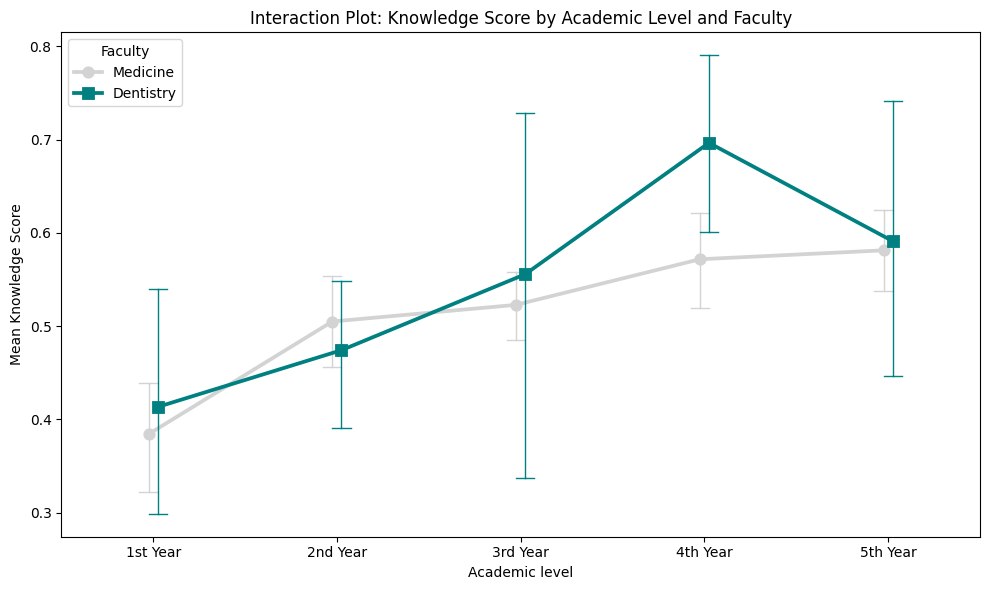

In [288]:
order = ["1st Year", "2nd Year", "3rd Year", "4th Year", "5th Year"]
plt.figure(figsize=(10, 6))
sns.pointplot(
    data=df,
    x="Academic level",
    y="knowledge_score",
    hue="Faculty",
    order=order,
    dodge=True,
    markers=["o", "s"],
    capsize=0.1,
    errwidth=1,
    palette=palette,
)
plt.title("Interaction Plot: Knowledge Score by Academic Level and Faculty")
plt.ylabel("Mean Knowledge Score")
plt.tight_layout()
plt.show()

The error bars in this graph show signify that results generated might have a high possibility of being affected by chance and randomness, this is especially evident in the dentistry group since the sample size is relatively small compared to medical students

#### Heatmaps
These are used to visualize the mean scores or proportions across two categorical variables (academic level & faculty)

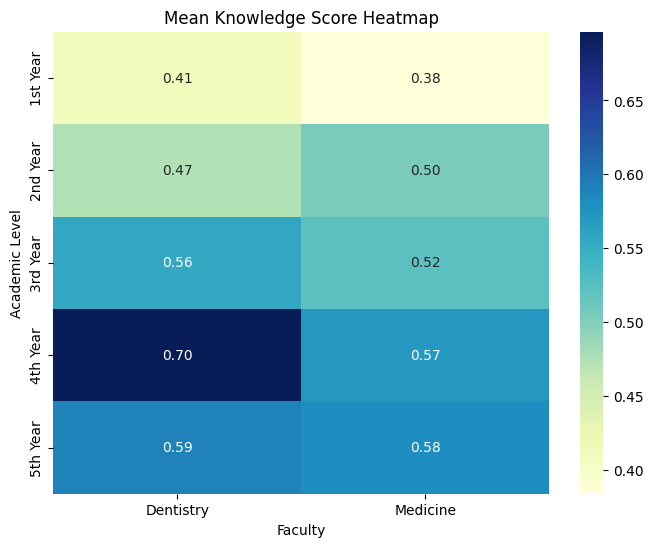

In [ ]:
pivot = df.pivot_table(
    index="Academic level", columns="Faculty", values="knowledge_score", aggfunc="mean"
)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Mean Knowledge Score Heatmap")
plt.ylabel("Academic Level")
plt.xlabel("Faculty")
plt.show()

#### Proportion Correct per Question (by Group)
To visualize the proportion of students who answered each question correctly by faculty

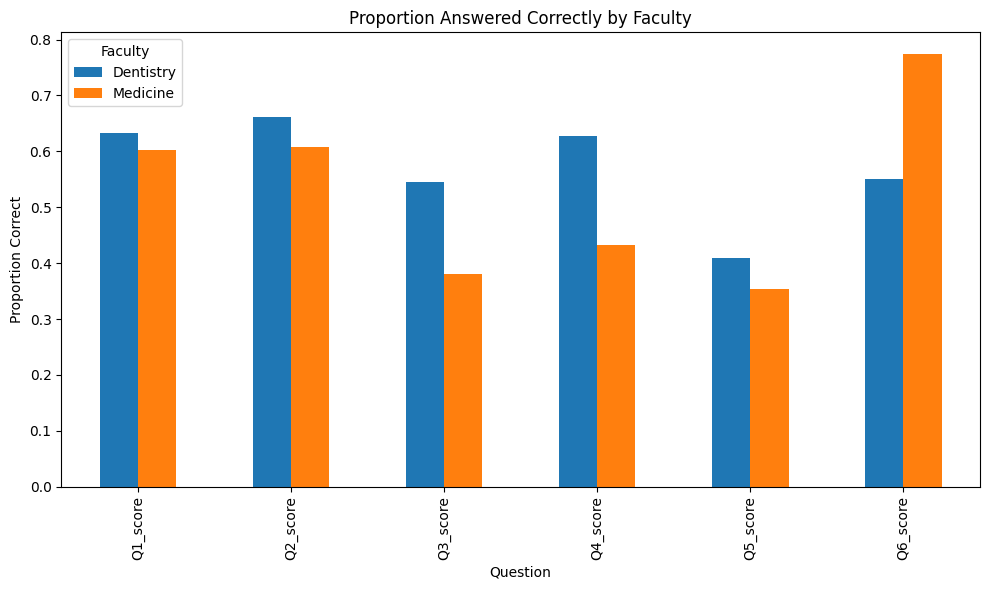

In [ ]:
score_cols = [col for col in df_knowledge.columns if col.endswith("_score")]
proportion_correct = df_knowledge.groupby("Faculty")[score_cols].mean().T

proportion_correct.plot(kind="bar", figsize=(10, 6))
plt.title("Proportion Answered Correctly by Faculty")
plt.ylabel("Proportion Correct")
plt.xlabel("Question")
plt.legend(title="Faculty")
plt.tight_layout()
plt.show()

In [ ]:
df[["RecordID", "Gender", "Faculty", "Academic level", "knowledge_score"]].to_csv(
    "../data/processed/knowledge_scores.csv", index=False
)